# Gaussian Mixture Model for IPOC data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from sklearn import mixture
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import GMM
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display

Pandas intro: http://pandas.pydata.org/pandas-docs/stable/10min.html

API: http://pandas.pydata.org/pandas-docs/stable/api.html


In [2]:
client = mongo_client.CERNMongoClient()
for e in client.get_all_collections():
    if 'I_STRENGTH' in e:
        print(e)
        
df = pd.DataFrame()
df = df.rename_axis("timestamps")

var = 'MKI.UA23.IPOC.AB1:T_LENGTH'
ddic = client.get_all_measurements_collection(var)
df = pd.concat([df, pd.DataFrame({var: ddic['values']}, index=pd.to_datetime(ddic['timestamps'], unit='s'))], axis=1)

var = 'MKI.UA23.IPOC.AB1:I_STRENGTH'
ddic = client.get_all_measurements_collection(var)
df = pd.concat([df, pd.DataFrame({var: ddic['values']}, index=pd.to_datetime(ddic['timestamps'], unit='s'))], axis=1)
print('------')
print(df.columns[0])
print(df.values[0])
#print(df[df.columns[0]]) # returns a Series with index
print(df[df.columns[0]].values) # returns a Series

# display(df, df.shape)
df.describe()

MKI.UA87.IPOC.BB2:I_STRENGTH
MKI.UA87.IPOC.AB2:I_STRENGTH
MKI.UA23.IPOC.CB1:I_STRENGTH
MKI.UA23.IPOC.BB1:I_STRENGTH
MKI.UA87.IPOC.CB2:I_STRENGTH
MKI.UA87.IPOC.DB2:I_STRENGTH
MKI.UA23.IPOC.AB1:I_STRENGTH
MKI.UA23.IPOC.DB1:I_STRENGTH
------
MKI.UA23.IPOC.AB1:T_LENGTH
[ 2.0737  1.9967]
[ 2.0737  2.0758  2.0775 ...,  3.4758  3.4758  3.4754]


MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:I_STRENGTH
count                30541.000000                  28618.000000
mean                     4.472024                      4.541761
std                     13.961999                      0.820200
min                      0.000000                     -0.000600
25%                      2.079200                      4.397400
50%                      2.081700                      4.817100
75%                      3.478100                      5.071700
max                    139.429700                      5.193100

In [9]:
#client = mongo_client.CERNMongoClient()
for e in client.get_all_collections():
    if 'BEAM_INTENSITY' in e:
        print(e)

# NameError: name 'dfi' is not defined
# dfi = dfi.drop(dfi.columns, axis=1)
dfi = pd.DataFrame()
dfi = dfi.rename_axis("timestamps")

var = 'LHC.BCTFR.A6R4.B1:BEAM_INTENSITY'
ddic = client.get_all_measurements_collection(var)
dfi = pd.concat([dfi, pd.DataFrame({var: ddic['values']}, index=pd.to_datetime(ddic['timestamps'], unit='s'))], axis=1)

var = 'MKI.A5L2.B1:TEMP_MAGNET_UP'
ddic = client.get_all_measurements_collection(var)
dfi = pd.concat([dfi, pd.DataFrame({var: ddic['values']}, index=pd.to_datetime(ddic['timestamps'], unit='s'))], axis=1)

# var = 'MKI.A5L2.B1:TEMP_MAGNET_DOWN'
# ddic = client.get_all_measurements_collection(var)
# dfi = pd.concat([dfi, pd.DataFrame({var: ddic['values']}, index=pd.to_datetime(ddic['timestamps'], unit='s'))], axis=1)

dfi.describe()


LHC.BCTFR.A6R4.B2:BEAM_INTENSITY
LHC.BCTFR.A6R4.B1:BEAM_INTENSITY


LHC.BCTFR.A6R4.B1:BEAM_INTENSITY  \
2016-09-23 20:57:38.735                               NaN   
2016-09-23 21:12:38.935                               NaN   
2016-09-23 21:27:39.137                               NaN   
2016-09-23 21:42:39.333                               NaN   
2016-09-23 21:57:39.531                               NaN   

                         MKI.A5L2.B1:TEMP_MAGNET_UP  
2016-09-23 20:57:38.735                        21.2  
2016-09-23 21:12:38.935                        21.2  
2016-09-23 21:27:39.137                        21.2  
2016-09-23 21:42:39.333                        21.2  
2016-09-23 21:57:39.531                        21.2

In [23]:
#get_all_measurements_collection deprecated, try with query_resample
# resample for 10 minutes now to reduce data (and computation time)
dfqr = client.query_resample("^.*BEAM_INTENSITY",'10T')
# adding temperature - different timestamps!
dftemp = client.query_resample_collection("MKI.A5L2.B1:TEMP_MAGNET_UP", '10T')
dfqr = pd.concat([dfqr,dftemp], axis=1)
display(dfqr.describe())
display(dfqr.head())

Fetching data for pattern ^.*BEAM_INTENSITY
Fetching data for LHC.BCTFR.A6R4.B2:BEAM_INTENSITY
Fetching data for LHC.BCTFR.A6R4.B1:BEAM_INTENSITY


series  LHC.BCTFR.A6R4.B2:BEAM_INTENSITY  LHC.BCTFR.A6R4.B1:BEAM_INTENSITY  \
count                       1.080000e+04                      1.080000e+04   
mean                        1.063221e+14                      1.057447e+14   
std                         9.952584e+13                      9.894507e+13   
min                         0.000000e+00                      0.000000e+00   
25%                         0.000000e+00                      0.000000e+00   
50%                         1.540536e+14                      1.507077e+14   
75%                         2.010750e+14                      1.992565e+14   
max                         2.669872e+14                      2.653757e+14   

series  MKI.A5L2.B1:TEMP_MAGNET_UP  
count                  8158.000000  
mean                     34.567173  
std                       8.367319  
min                      21.000000  
25%                      26.300000  
50%                      36.100000  
75%                      41.950000  
max                      49.000000

series               LHC.BCTFR.A6R4.B2:BEAM_INTENSITY  \
timestamps                                              
2016-06-30 22:00:00                               0.0   
2016-06-30 22:10:00                               0.0   
2016-06-30 22:20:00                               0.0   
2016-06-30 22:30:00                               0.0   
2016-06-30 22:40:00                               0.0   

series               LHC.BCTFR.A6R4.B1:BEAM_INTENSITY  \
timestamps                                              
2016-06-30 22:00:00                               0.0   
2016-06-30 22:10:00                               0.0   
2016-06-30 22:20:00                               0.0   
2016-06-30 22:30:00                               0.0   
2016-06-30 22:40:00                               0.0   

series               MKI.A5L2.B1:TEMP_MAGNET_UP  
timestamps                                       
2016-06-30 22:00:00                        36.8  
2016-06-30 22:10:00                         NaN  
2016-06-30 22:20:00                        36.8  
2016-06-30 22:30:00                        36.8  
2016-06-30 22:40:00                         NaN

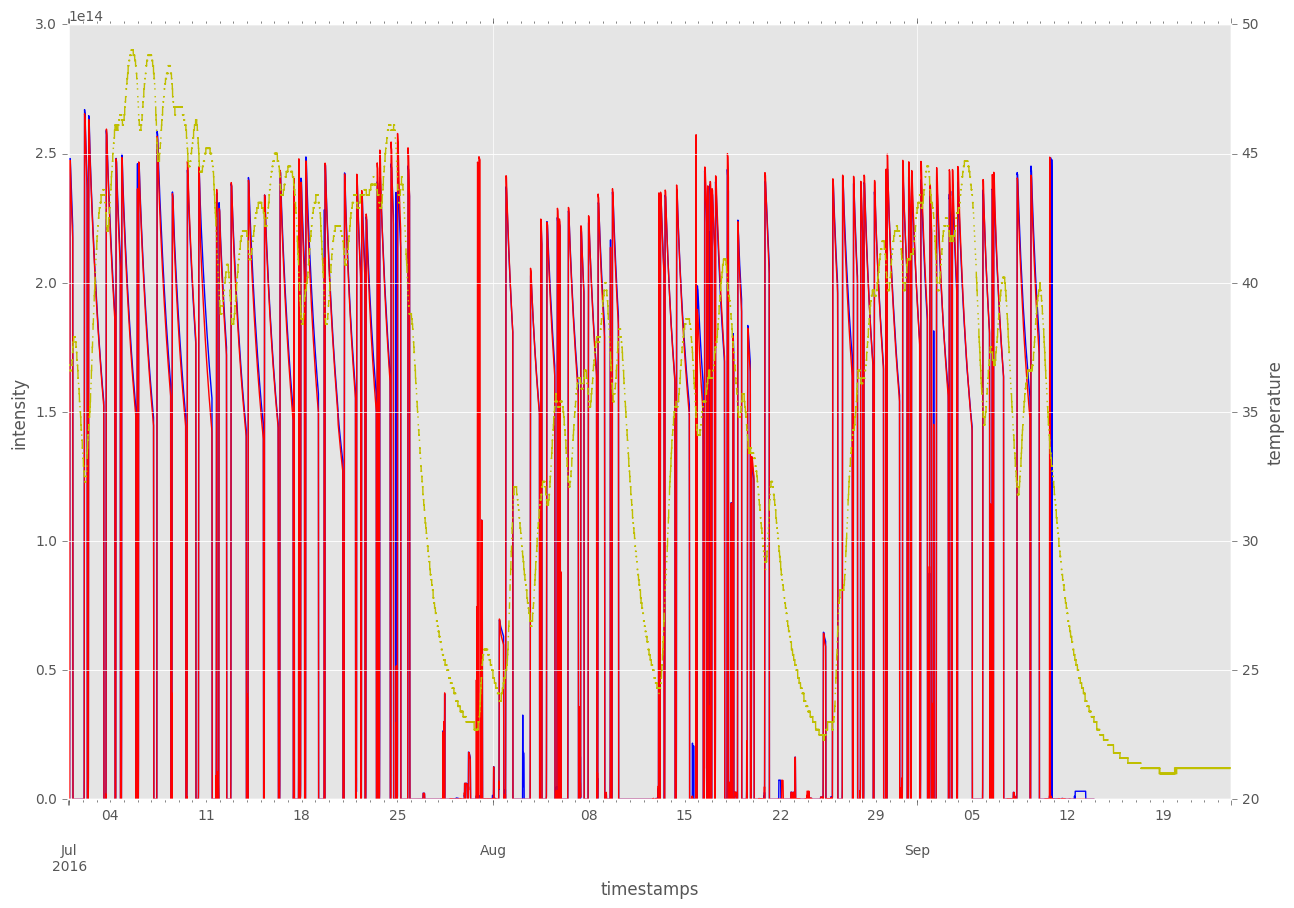

In [24]:
fig, ax = plt.subplots(figsize=(15,10)) # figsize in inches
ax2 = ax.twinx()
dfqr[dfqr.columns[0]].plot(ax=ax, style='b-')
dfqr[dfqr.columns[1]].plot(ax=ax, style='r-')
dfqr[dfqr.columns[2]].plot(ax=ax2, style='y-')
ax.set_ylabel("intensity")
ax2.set_ylabel("temperature")

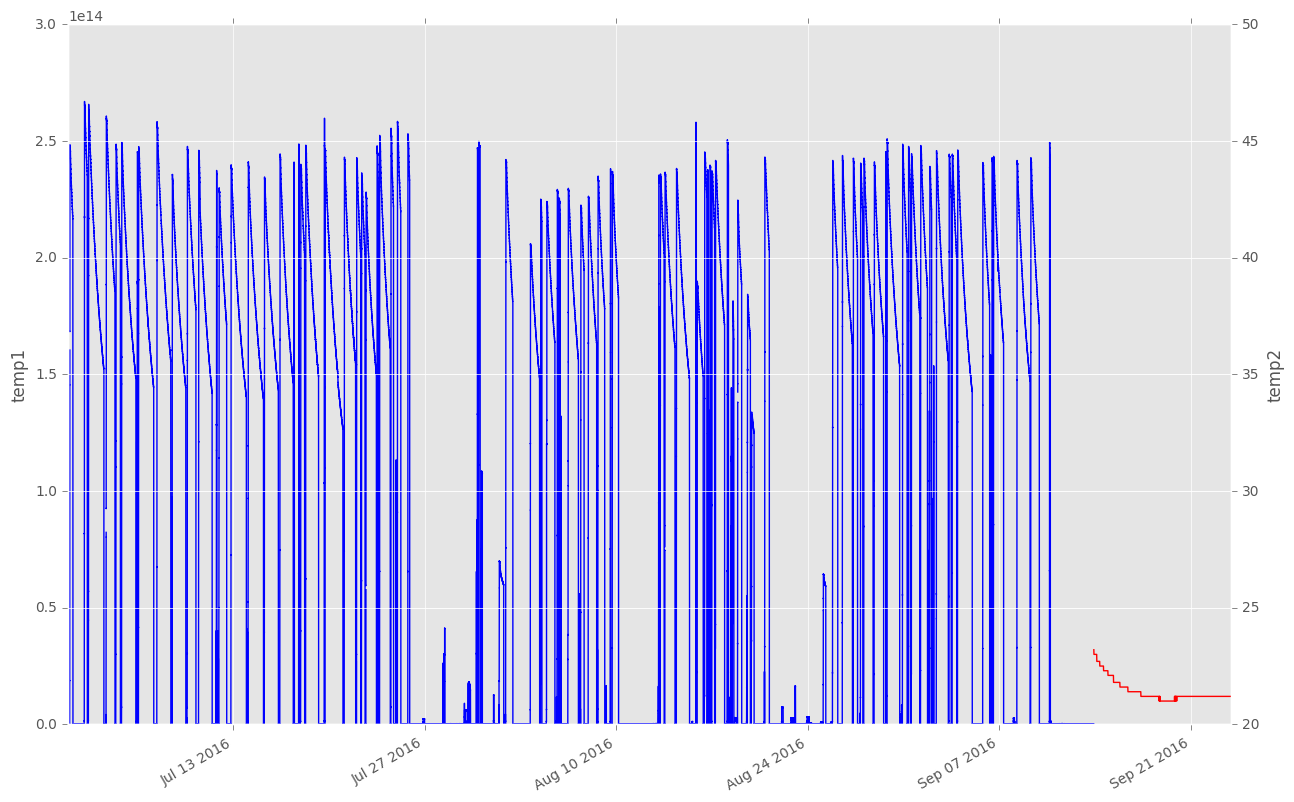

In [6]:
fig, ax = plt.subplots(figsize=(15,10)) # figsize in inches
ax2 = ax.twinx()
dfi[dfi.columns[0]].plot(ax=ax, style='b-')
dfi[dfi.columns[1]].plot(ax=ax2, style='r-')
ax.set_ylabel("intensity")
ax2.set_ylabel("temperature")

Plotting info for Pandas dataframes:
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

In case more than 2 axes: http://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes

<font color='red'>Plotting does *not* work because beam_intensity is sampled at different stamps!</font>


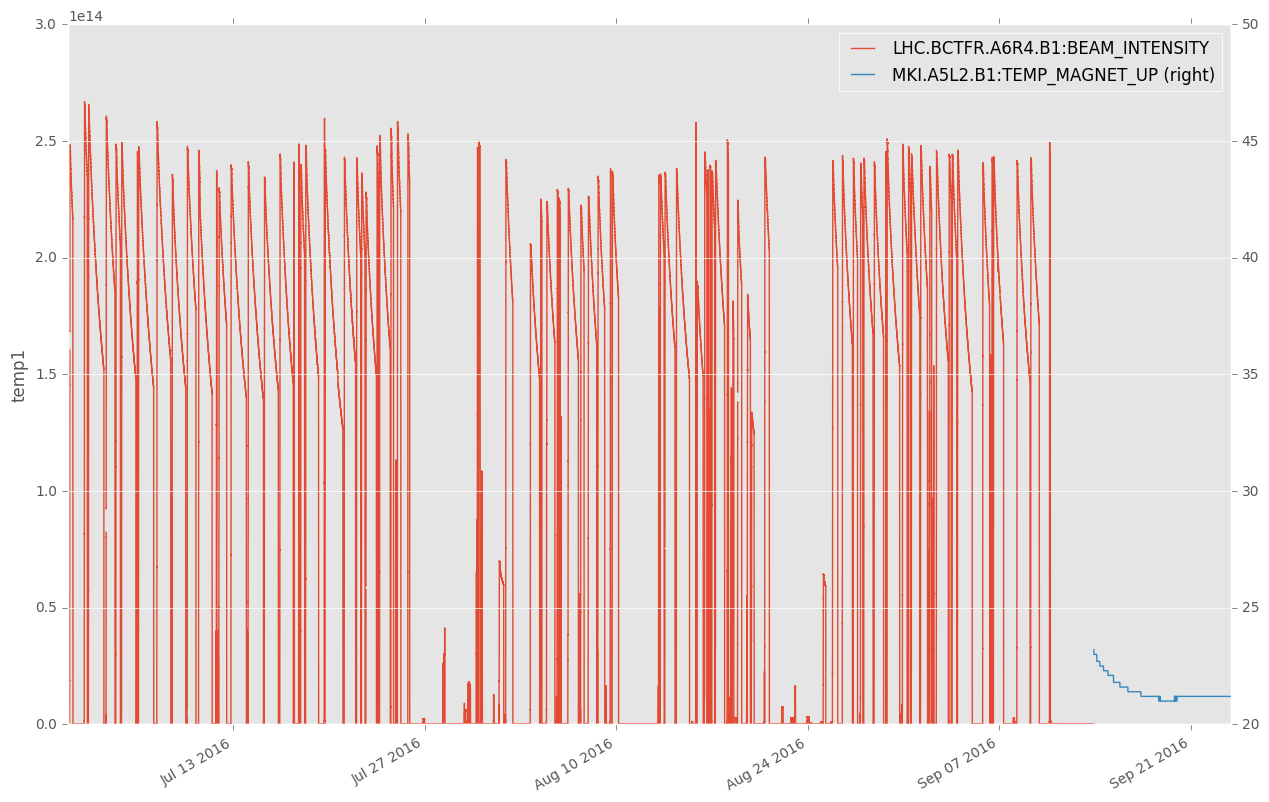

In [12]:
fig, ax = plt.subplots(figsize=(15,10)) # figsize in inches
dfi.plot(ax=ax, secondary_y=dfi.columns[1])
ax.set_ylabel("temp1")



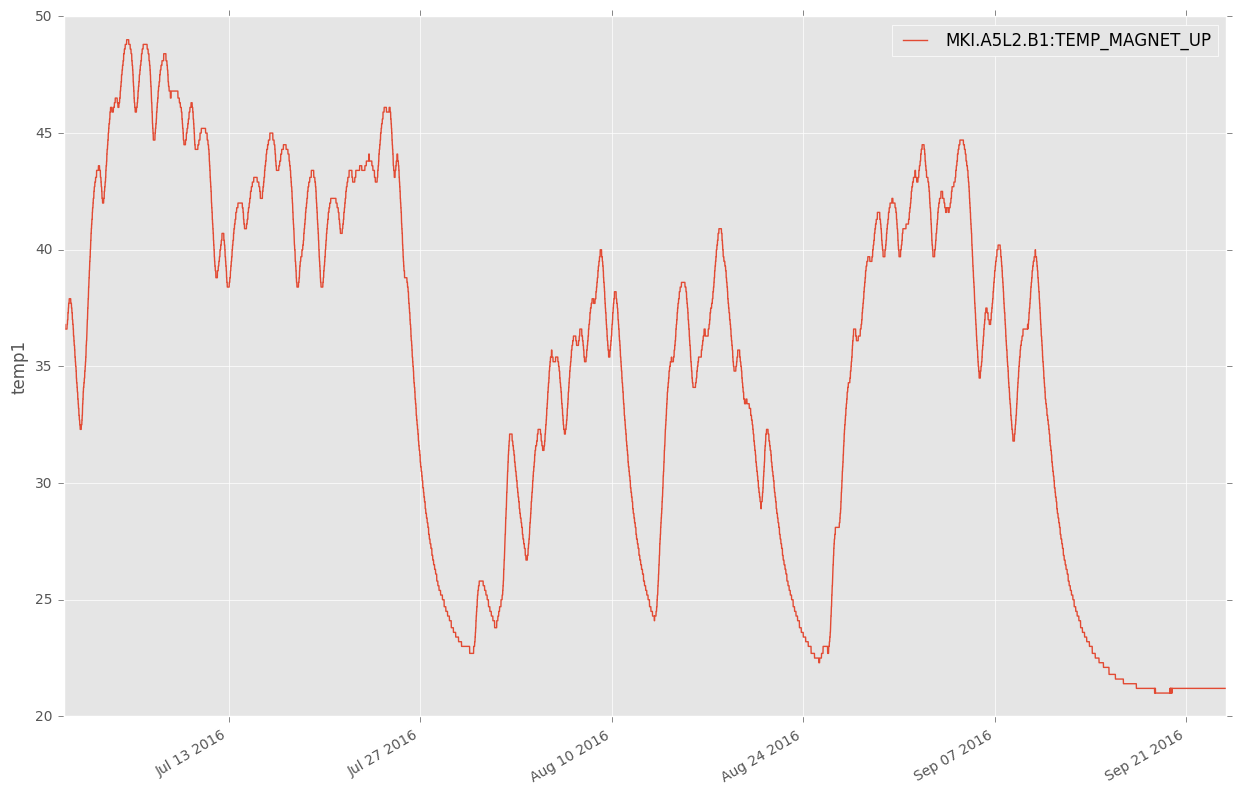

In [13]:
# plot only temperature, right under the other plot
dfi = dfi.drop(dfi.columns, axis=1)
dfi = pd.DataFrame()
dfi = dfi.rename_axis("timestamps")

var = 'MKI.A5L2.B1:TEMP_MAGNET_UP'
ddic = client.get_all_measurements_collection(var)
dfi = pd.concat([dfi, pd.DataFrame({var: ddic['values']}, index=pd.to_datetime(ddic['timestamps'], unit='s'))], axis=1)

fig2, ax = plt.subplots(figsize=(15,10)) # figsize in inches
dfi.plot(ax=ax)
ax.set_ylabel("temp1")

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # figsize in inches
df.plot(ax=axes)
axes.set_ylabel("pulse-length")

Looks like I didn't provide enough data for the I_STRENGTH variables ...

# Filter based on I_STRENGTH>1kA

Some plotting info here: https://bespokeblog.wordpress.com/2011/07/07/basic-data-plotting-with-matplotlib-part-2-lines-points-formatting/

In [15]:
dff = df[(df['MKI.UA23.IPOC.AB1:I_STRENGTH']>1)]
dff.describe()

MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:I_STRENGTH
count                28426.000000                  28426.000000
mean                     3.020580                      4.572438
std                      1.639605                      0.732802
min                      2.059400                      1.450600
25%                      2.079200                      4.442725
50%                      2.081700                      4.817300
75%                      3.477900                      5.072000
max                      9.355800                      5.193100

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10)) # figsize in inches
#plt.figure(figsize=(150,100));
#dff.plot(kind='scatter', y=df.columns[0], x=df.index.values[0])
dff.plot(ax=axes, kind='line', marker='o', linestyle='none')